## Challenge 3 (4 points)
- Use the data file challenge3.gwf with channel H1:CHALLENGE3.
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- The data contain a loud simulated signal with m1 = m2 = 10 solar masses.
1. What is the merger time of this signal?
2. What is the matched-filter SNR of this signal?

Importing the necessary libraries.

In [8]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

Loading the data.

In [2]:
data = TimeSeries.read("challenge3.gwf", channel = "H1:CHALLENGE3")

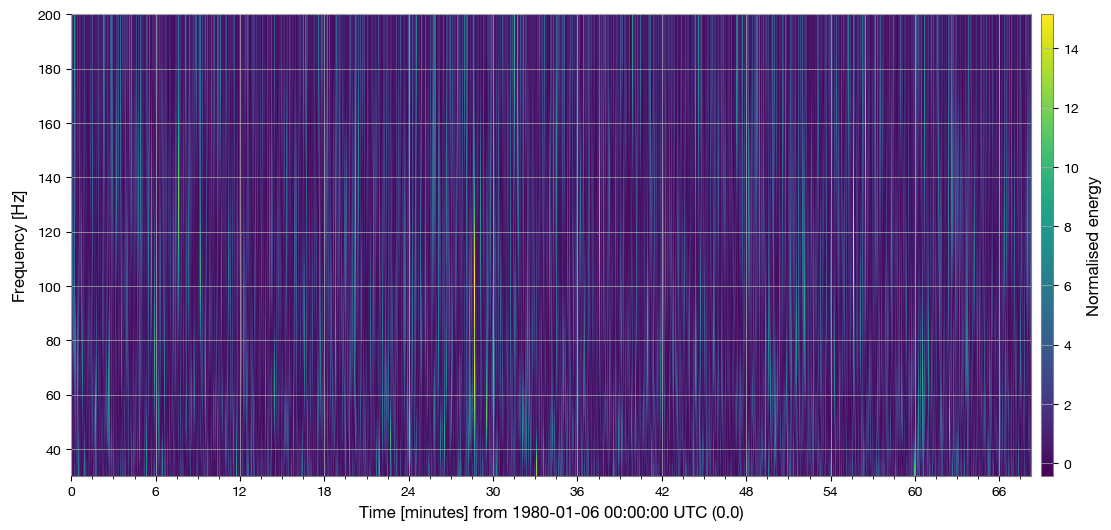

In [3]:
hq = data.q_transform(frange=(30, 200))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

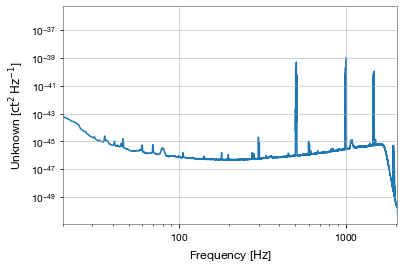

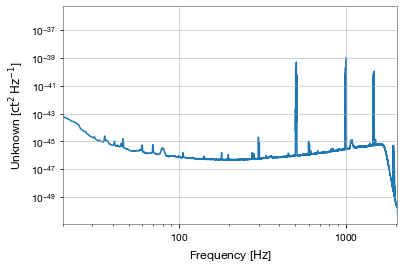

In [4]:
psd = data.psd(fftlength=4, overlap=2)
nyquist_freq = data.sample_rate.value / 2

# Plot from 20 Hz up to Nyquist
psd.plot(xscale='log', yscale='log', xlim=(20, nyquist_freq))

In [5]:
from pycbc.types import TimeSeries as pycbc_TimeSeries
conditioned=pycbc_TimeSeries(data.value,delta_t=data.dt.value)
dt = conditioned.delta_t
duration = conditioned.duration

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

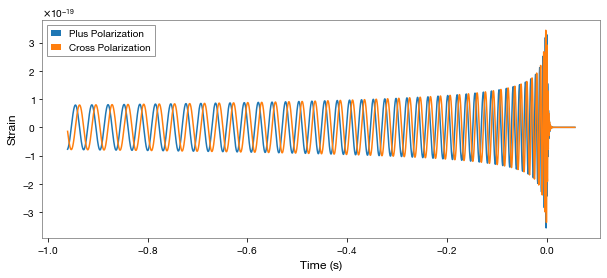

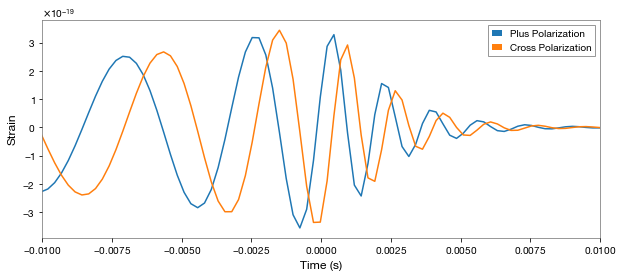

In [10]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=15,
                         mass2=15,
                         delta_t=dt,
                         f_lower=30)

plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.show()

# Zoom in near the merger time
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

In [11]:
hp.resize(len(conditioned))

In [12]:
template = hp.cyclic_time_shift(hp.start_time)

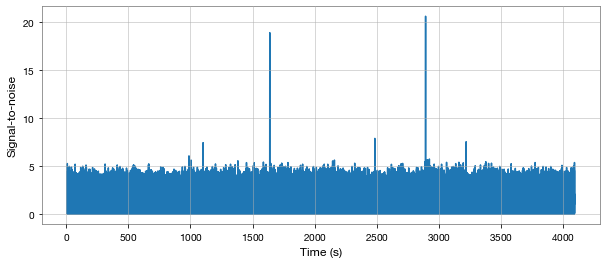

We found a signal at 2892.71142578125s with SNR 20.55668899833454


In [13]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))